In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
from datetime import  datetime

In [32]:
## Read the transformed data
data = pd.read_csv("data/main_df.csv")

In [7]:
## Read the original fred data
fred_data = pd.read_csv("data/fred_data.csv")

In [5]:
fred_data.head()

,date,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,...,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,VXOCLSx
0,1959-01-01,2437.296,2288.8,17.302,292258.8329,18235.77392,22.6250,23.4581,22.1904,32.4078,...,11.358,2.13,2.45,2.04,NaN,274.9,6476.0,12298.0,84.2043,NaN
1,1959-02-01,2446.902,2297.0,17.482,294429.5453,18369.56308,23.0681,23.7747,22.3827,32.6455,...,11.375,2.14,2.46,2.05,NaN,276.0,6476.0,12298.0,83.5280,NaN
2,1959-03-01,2462.689,2314.0,17.647,293425.3813,18523.05762,23.4004,23.9186,22.4925,32.6455,...,11.395,2.15,2.45,2.07,NaN,277.4,6508.0,12349.0,81.6405,NaN
3,1959-04-01,2478.744,2330.3,17.584,299331.6505,18534.46600,23.8989,24.2641,22.8221,33.1606,...,11.436,2.16,2.47,2.08,NaN,278.1,6620.0,12484.0,81.8099,NaN
4,1959-05-01,2493.228,2345.8,17.796,301372.9597,18679.66354,24.2589,24.4655,23.0418,33.3190,...,11.454,2.17,2.48,2.08,95.3,280.1,6753.0,12646.0,80.7315,NaN


In [16]:
index_data = pd.read_csv("data/index_data.csv")

In [18]:
index_data.columns

Index(['date', 'Index', 'D12', 'E12', 'b/m', 'tbl', 'AAA', 'BAA', 'lty',
       'ntis', 'Rfree', 'infl', 'ltr', 'corpr', 'svar', 'csp', 'CRSP_SPvw',
       'CRSP_SPvwx'],
      dtype='object')

In [15]:
cols = list(fred_data.columns)
cols.remove("date")
cols = ["transformed_{}".format(x) for x in cols]

In [19]:
target_variable = ["returns"]
##
transformed_variables_list = cols + ["D12","E12", "b/m", "tbl", "AAA", "BAA", "lty", "ntis",
                                    "Rfree", "infl", "ltr", "corpr", "svar", "csp", "CRSP_SPvw", "CRSP_SPvwx"]



In [33]:
## Process datetime columns
data["date"] = data["date"].apply(lambda x:datetime.strptime(x,"%Y-%m-%d").date())
data.set_index("date",inplace=True)

In [34]:
## Begin with simple analysis of single variable regression for returns
target = data["returns"]

In [35]:
## Plotting functions for time series
def plot_series(tseries, xlabel, ylabel, title, new_fig=True, label=""):
    if new_fig:
        plt.figure(figsize=(8,6))
    plt.plot(tseries,label=label)
    plt.xlabel(xlabel, size=15)
    plt.ylabel(ylabel, size=15)
    plt.title(title, size=15)
    plt.xticks(size=15)
    plt.yticks(size=15)

<IPython.core.display.Javascript object>


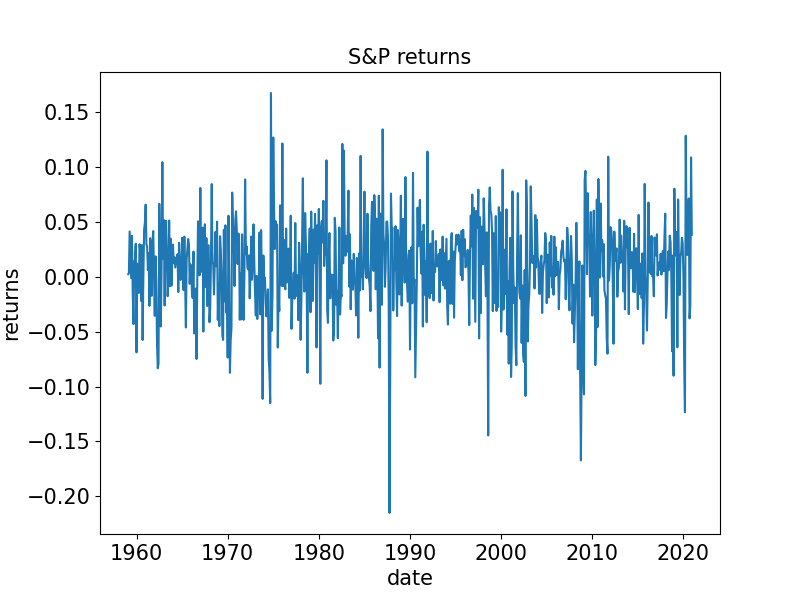

In [40]:
plot_series(target,"date","returns","S&P returns")

<IPython.core.display.Javascript object>


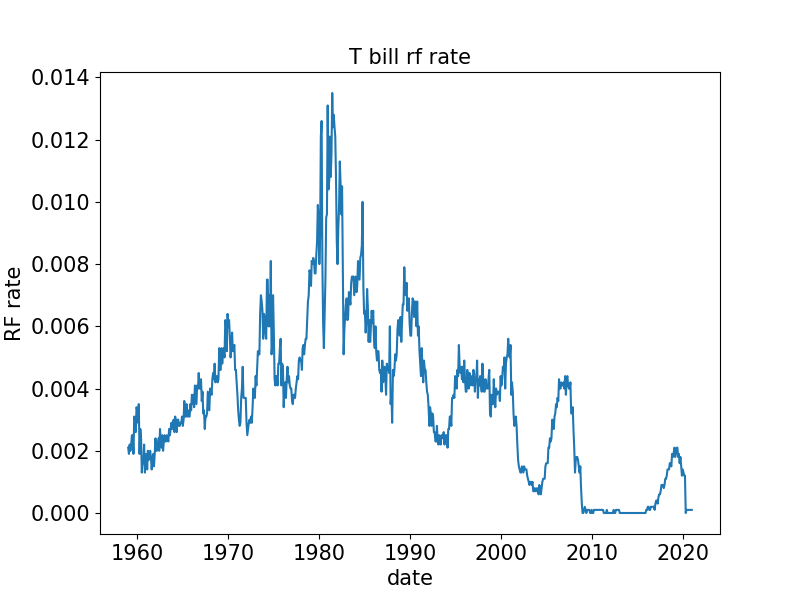

In [41]:
## Compute equity premia
## Subtract risk free rate
plot_series(data["Rfree"], "date","RF rate", "T bill rf rate")

In [42]:
## equity risk premia
equity_premia = target - data["Rfree"]

<IPython.core.display.Javascript object>


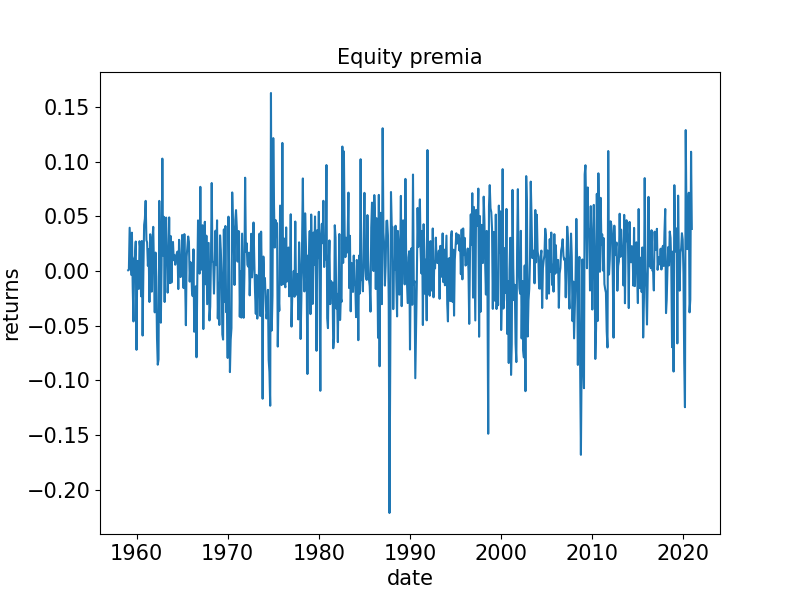

In [44]:
plot_series(equity_premia,"date","returns","Equity premia")

<IPython.core.display.Javascript object>


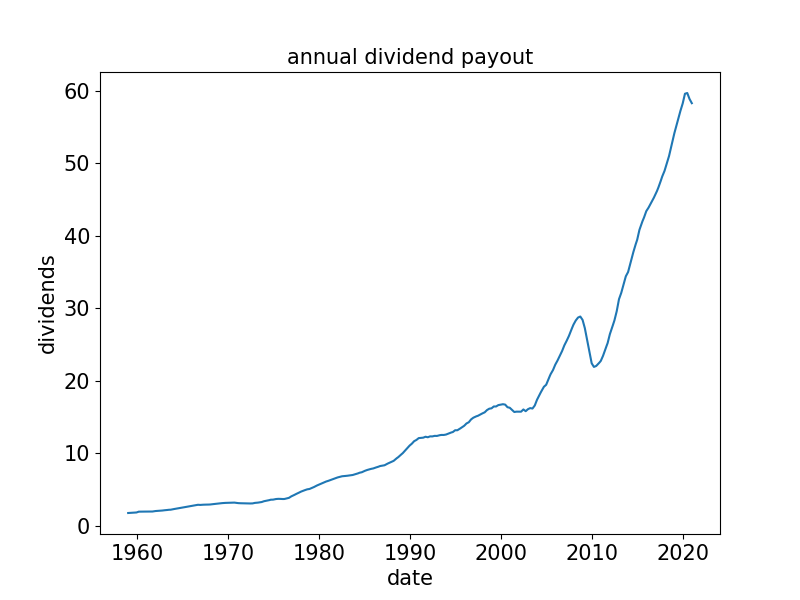

In [46]:
## Check dividends time series
plot_series(data["D12"], "date","dividends","annual dividend payout")

<IPython.core.display.Javascript object>


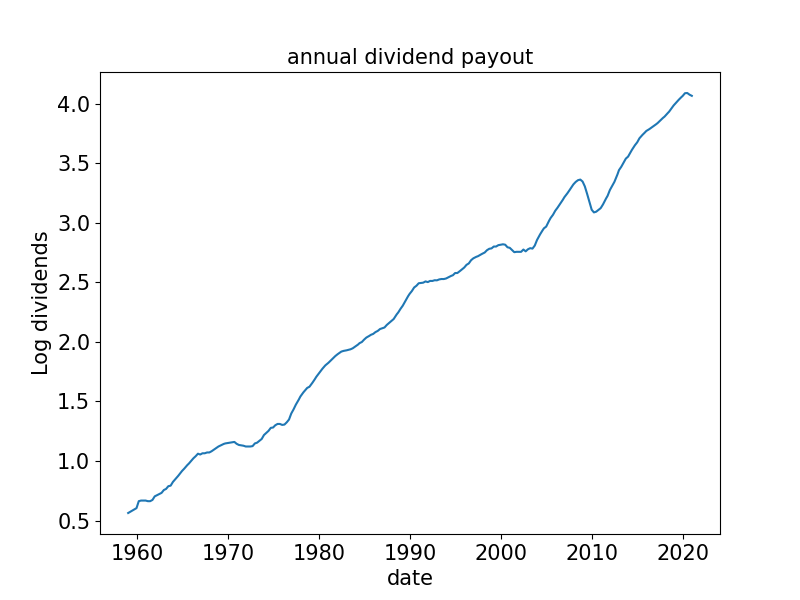

In [47]:
## Take log dividends
plot_series(np.log(data["D12"]), "date","Log dividends","annual dividend payout")

In [48]:
data["D12"].head()

date
1959-01-01    1.75667
1959-02-01    1.76333
1959-03-01    1.77000
1959-04-01    1.77667
1959-05-01    1.78333
Name: D12, dtype: float64

In [50]:
data["D12"].head().shift()

date
1959-01-01        NaN
1959-02-01    1.75667
1959-03-01    1.76333
1959-04-01    1.77000
1959-05-01    1.77667
Name: D12, dtype: float64

<IPython.core.display.Javascript object>


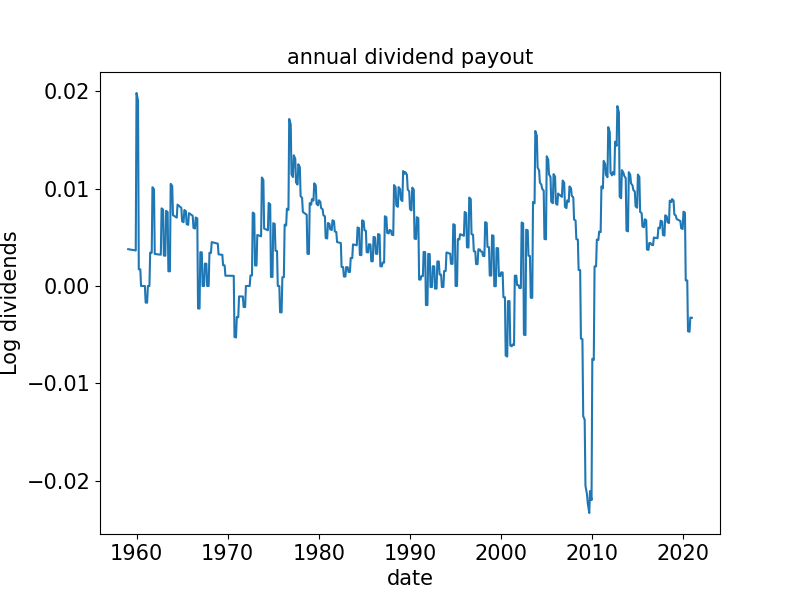

In [51]:
# Take log difference of dividends 
plot_series(np.log(data["D12"]).iloc[1:] - np.log(data["D12"].shift().dropna()), 
            "date","Log dividends","annual dividend payout")

In [58]:
import statsmodels.api as sm

In [71]:
### Step 1: Write code to train simple OLS models in static fashion
def train_static_ols(Y,X,lag_x = 0, add_constant=True, robust_cov = False):
    # Get dateindex from Y and X
    if lag_x:
        X = X.shift(lag_x)
        X = X.dropna()
        date_y = Y.index
        date_x = X.index
        common_dates = sorted(list(set(date_y).intersection(set(date_x))))
        Y = Y.loc[common_dates]
        X = X.loc[common_dates]
    
    if add_constant:
        X = sm.add_constant(X)
    
    if robust_cov:
        ols = sm.OLS(Y,X).fit(cov_type="robust")
    else:
        ols = sm.OLS(Y,X).fit()
    return ols

In [72]:
Y = equity_premia
X = np.log(data["D12"]).iloc[1:] - np.log(data["D12"].shift().dropna())

In [77]:
model1 = train_static_ols(Y, X, lag_x=1, add_constant=True)

In [78]:
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.827
Date:                Fri, 30 Apr 2021   Prob (F-statistic):              0.177
Time:                        16:59:41   Log-Likelihood:                 1287.8
No. Observations:                 742   AIC:                            -2572.
Df Residuals:                     740   BIC:                            -2562.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0073      0.002      3.508      0.000       0.003       0.011
D12           -0.3853      0.285     -1.351      0.177      -0.945       0.174
==============================================================================
Omnibus:                       58.157   Durbin-Watson:                   1.934
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              126.537
Skew:                          -0.463   Prob(JB):                     3.33e-28
Kurtosis:                       4.799   Cond. No.                         182.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
model1.predict()

In [113]:
### Write a function for rolling OLS. Use it for predictions as well
def rolling_OLS_estimation(Y,X,train_rolling_length = 60, test_rolling_length = 1, 
                           lag_x=0, add_constant=True, robust_cov = "HC0"):
    if lag_x:
        X = X.shift(lag_x)
        X = X.dropna()
        date_y = Y.index
        date_x = X.index
        common_dates = sorted(list(set(date_y).intersection(set(date_x))))
        Y = Y.loc[common_dates]
        X = X.loc[common_dates]
    
    predictions = []
    int_start  = 0
    for int_end in range(train_rolling_length, len(common_dates), test_rolling_length):
        # Define intervals
        train_interval = common_dates[int_start:int_end]
        test_interval = common_dates[int_end:int_end+test_rolling_length]
        # Training data
        Yt = Y.loc[train_interval]
        Xt = X.loc[train_interval]
        # Testing data
        Xt_test = X.loc[test_interval]
        if add_constant:
            Xt = sm.add_constant(Xt, has_constant="add")
            Xt_test = sm.add_constant(Xt_test, has_constant="add")
        ols = sm.OLS(Yt, Xt).fit(cov_type=robust_cov)
        # Perform prediction
        Yt_pred = ols.predict(Xt_test)
        predictions.append(Yt_pred)
        # Update index
        int_start += test_rolling_length
        
    pred_df = pd.concat(predictions)
    return pred_df
        
        

In [191]:
predictions = rolling_OLS_estimation(Y, X, train_rolling_length=120, lag_x=1, add_constant=True)

<IPython.core.display.Javascript object>


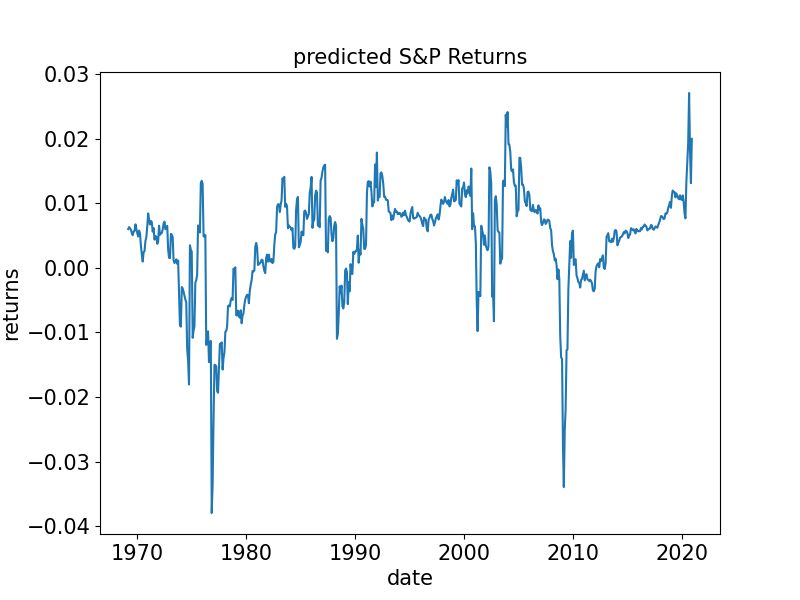

In [192]:
plot_series(predictions, "date","returns","predicted S&P Returns")

In [193]:
## Write function for backtesting returns
## Plotting functions for time series
def plot_multiple_series(tseries_list, xlabel, ylabel, title, new_fig=True, label_list=[]):
    if new_fig:
        plt.figure(figsize=(8,6))
    for tseries, label in zip(tseries_list, label_list):
        plt.plot(tseries,label=label)
        plt.xlabel(xlabel, size=15)
        plt.ylabel(ylabel, size=15)
        plt.title(title, size=15)
        plt.xticks(size=15)
        plt.yticks(size=15)

In [194]:
def cut_equal_timseries(tseries_list):
    """
    Return same length of time series of multiple series
    """
    datelist = [list(tseries.index) for tseries in tseries_list]
    common_dates = set(datelist[0])
    for tseries in datelist[1:]:
        common_dates.intersection_update(tseries)
    common_dates = sorted(list(common_dates))
    tseries_list = [tseries.loc[common_dates] for tseries in tseries_list]
    return tseries_list

<IPython.core.display.Javascript object>


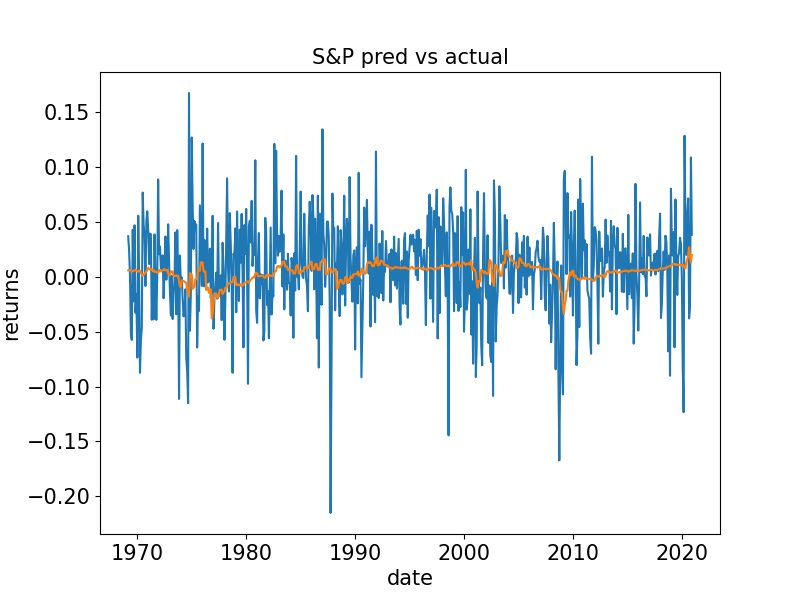

In [195]:
ret,pred = cut_equal_timseries([data["returns"],predictions])

plot_multiple_series([ret,pred],"date","returns","S&P pred vs actual", label_list=["actual","forecast"])

In [196]:
import sklearn
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

In [197]:
def performace_metrics(yactual, ypred_list, prediction_names_list):
    # RMSE, MAE, R2
    r2_list = []
    mae_list = []
    rmse_list = []
    mape_list = []
    
    for pred in ypred_list:
        r2_list.append(r2_score(yactual, pred))
        mae_list.append(mean_absolute_error(yactual, pred))
        mape_list.append(mean_absolute_percentage_error(yactual, pred))
        rmse_list.append(mean_squared_error(yactual, pred))

    metric_names = ["R2 coeff","mae", "mape", "rmse"]
    results = pd.DataFrame([r2_list, mae_list, mape_list, rmse_list]).T
    results.columns = metric_names
    results.index = prediction_names_list
    return results

In [198]:
performace_metrics(ret, [pred],["simple pred"])

,R2 coeff,mae,mape,rmse
simple pred,-0.036482,0.033847,1.519482,0.002012


In [199]:
## Create trading strategy
def trading_strategy(yactual, ypred):
    # strat 1: Long on market
    strat1_ret = yactual
    # strat 2: Long if pred positive, short if pred negative
    bool_temp = [1 if x > 0 else -1 for x in ypred.values]
    strat2_ret = yactual*bool_temp
    # strat 3: 2x long if pred positive, 0 if pred negative
    bool_temp = [2 if x > 0 else 0 for x in ypred.values]
    strat3_ret = yactual*bool_temp
    # strat 4: 1x long if pred positive, 0 if pred negative
    bool_temp = [1 if x > 0 else 0 for x in ypred.values]
    strat4_ret = yactual*bool_temp
    
    ret_df = pd.DataFrame([strat1_ret, strat2_ret, strat3_ret, strat4_ret]).T
    ret_df.columns = ["Strategy 1", "Strategy 2", "Strategy 3", "Strategy 4"]
    
    # Cumulative return
    cum_ret = ret_df + 1
    cum_ret = cum_ret.cumprod()
    return ret_df, cum_ret

In [200]:
ret_df, cum_ret_df = trading_strategy(ret, pred)

In [201]:
ret_df.head(20)

,Strategy 1,Strategy 2,Strategy 3,Strategy 4
date,,,,
1969-03-01,0.037077,0.037077,0.074153,0.037077
1969-04-01,0.024029,0.024029,0.048058,0.024029
1969-05-01,0.000289,0.000289,0.000579,0.000289
1969-06-01,-0.053056,-0.053056,-0.106112,-0.053056
1969-07-01,-0.057503,-0.057503,-0.115006,-0.057503
1969-08-01,0.042927,0.042927,0.085853,0.042927
1969-09-01,-0.022275,-0.022275,-0.044550,-0.022275
1969-10-01,0.047066,0.047066,0.094132,0.047066
1969-11-01,-0.032568,-0.032568,-0.065137,-0.032568


<IPython.core.display.Javascript object>


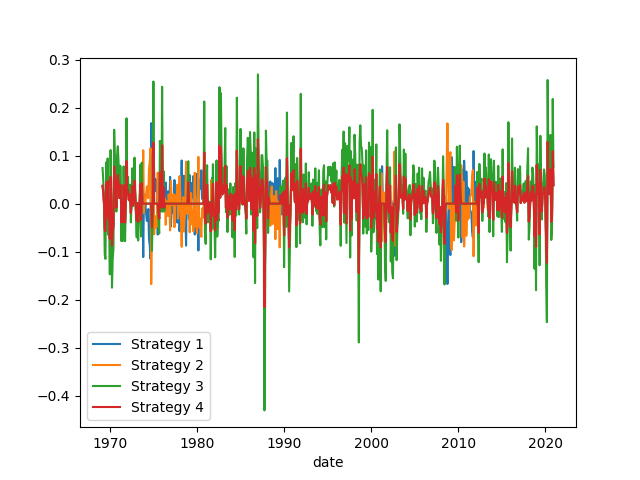

<AxesSubplot:xlabel='date'>

In [202]:
ret_df.plot()

<IPython.core.display.Javascript object>


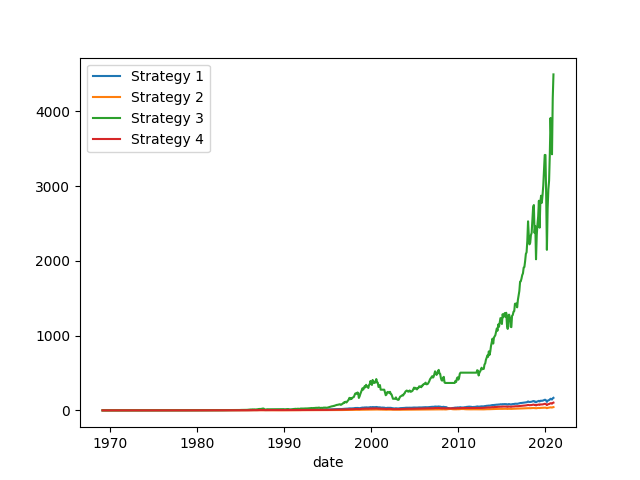

<AxesSubplot:xlabel='date'>

In [203]:
cum_ret_df.plot()

<IPython.core.display.Javascript object>


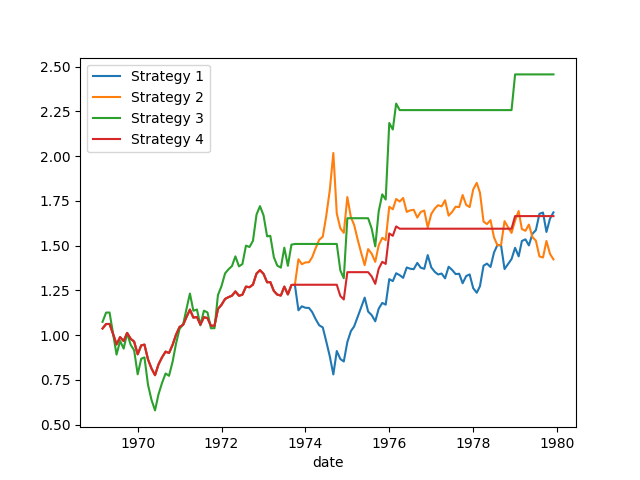

<AxesSubplot:xlabel='date'>

In [204]:
## Plot for initial 20 years
cum_ret_df.loc[cum_ret_df.index < datetime(1980,1,1).date()].plot()

<IPython.core.display.Javascript object>


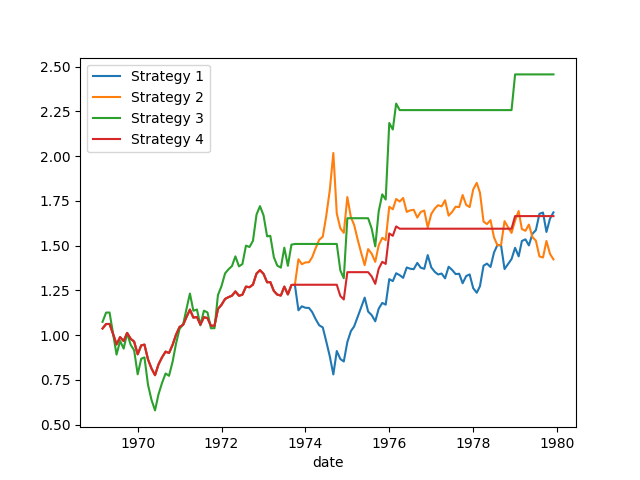

<AxesSubplot:xlabel='date'>

In [205]:
## Plot for initial 20 years
cum_ret_df.loc[cum_ret_df.index < datetime(1980,1,1).date()].plot()